In [1]:
%pip install matplotlib tensorboard mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 8.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 9.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.0/296.0 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 1.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 820.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 919.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 1.0 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 867.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 894.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━

In [1]:
## Standard libraries
import os
import math
import numpy as np
import time
import pandas as pd
import torch

## Progress bar
from tqdm.notebook import tqdm
## Imports for plotting
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba

/tmp/ipykernel_58/4083129496.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
s = pd.Series([1, 3, 5, np.nan, 6, 8])

In [3]:
class MyModule(nn.Module):

    def __init__(self):
        super().__init__()
        # Some init for my module

    def forward(self, x):
        # Function for performing the calculation of the module.
        pass
    
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [4]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


In [5]:
import torch.utils.data as data

class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([ 1.0185, -0.0981]), tensor(1))


In [6]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

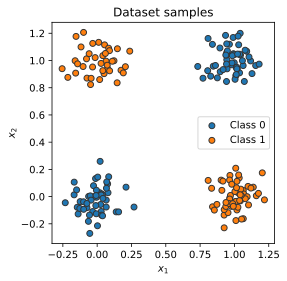

In [7]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [8]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 0.9251, -0.1357],
        [-0.1386, -0.1277],
        [ 0.9673,  0.1556],
        [-0.0117,  0.1327],
        [ 0.9418,  1.0396],
        [ 0.0600,  1.0519],
        [ 1.0178,  0.9392],
        [ 0.9622, -0.0510]])
Data labels torch.Size([8]) 
 tensor([1, 0, 1, 0, 0, 1, 0, 1])


In [10]:
loss_module = nn.BCEWithLogitsLoss()
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)


In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [12]:
import mlflow
import mlflow.sklearn

def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()
            
            ## Step 6: Take the running average of the loss
            epoch_loss += loss.item()
        
        # Add average loss
        epoch_loss /= len(data_loader)
        mlflow.log_metric("epoch_loss", epoch_loss) #much slower if it's here

    return (num_epochs, loss)

In [13]:
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [14]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")
    return acc

In [18]:
from urllib.parse import urlparse

mlflow.set_tracking_uri("http://mlflow:5001")
mlflow.set_experiment("/my-experiment")

with mlflow.start_run():
        num_epochs, loss = train_model(model, optimizer, train_data_loader, loss_module)
        print(num_epochs)
        print(loss.item())

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        print(tracking_url_type_store)
        
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_metric("loss", loss.item()) #much slower if it's here

        # Model registry does not work with file store
        #if tracking_url_type_store != "file":

            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.pytorch.log_model(model, "model", registered_model_name="ElasticnetWineModel")
        #else:
        #mlflow.sklearn.log_model(model, "model")
            
            
        test_dataset = XORDataset(size=500)
        # drop_last -> Don't drop the last batch although it is smaller than 128
        test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)
        acc = eval_model(model, test_data_loader)
        mlflow.log_metric("acc", acc)

  0%|          | 0/100 [00:00<?, ?it/s]

100
0.0030076662078499794
http


Registered model 'ElasticnetWineModel' already exists. Creating a new version of this model...
2022/12/01 20:28:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ElasticnetWineModel, version 3


Accuracy of the model: 100.00%


Created version '3' of model 'ElasticnetWineModel'.


0.003687213873490691